In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

# Step 1: Data Collection

Obtain historical Bitcoin price data from Yahoo Finance from the last 5 years

In [2]:
crypto_symbol = 'BTC-USD'
start_date = '2019-01-01'
end_date = '2024-12-31'

df_btc = yf.download(crypto_symbol, start=start_date, end=end_date)
df_btc.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824


# Step 2: Data Preprocessing
Prepare the data through cleaning and preprocessing. Ensure the date column is in date-time format, remove duplicates, handle any missing values and check for outliers.

In [3]:
# Resetting the index
df_btc.reset_index(inplace=True)

# Check for missing values and remove them if any
df_btc.dropna(inplace=True)

# Check for duplicate entries and remove them if any
df_btc.drop_duplicates(inplace=True)

# Drop duplicate columns
df_btc.drop(columns=['Adj Close'], inplace=True)

df_btc.head()

,Date,Open,High,Low,Close,Volume
0,2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,4324200990
1,2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,5244856836
2,2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,4530215219
3,2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,4847965467
4,2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,5137609824


In [4]:
# Check the data types of the columns
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748 entries, 0 to 1747
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1748 non-null   datetime64[ns]
 1   Open    1748 non-null   float64       
 2   High    1748 non-null   float64       
 3   Low     1748 non-null   float64       
 4   Close   1748 non-null   float64       
 5   Volume  1748 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 82.1 KB


In [5]:
# Check summary statistics
df_btc.describe()

,Date,Open,High,Low,Close,Volume
count,1748,1748.000000,1748.000000,1748.000000,1748.000000,1.748000e+03
mean,2021-05-23 12:00:00,23989.794417,24539.615229,23390.264328,24000.754050,2.941528e+10
min,2019-01-01 00:00:00,3401.376465,3427.945557,3391.023682,3399.471680,4.324201e+09
25%,2020-03-12 18:00:00,9532.409424,9699.815674,9374.281494,9535.120361,1.720069e+10
50%,2021-05-23 12:00:00,20777.357422,21348.091797,20343.182617,20798.910156,2.615681e+10
75%,2022-08-03 06:00:00,35106.605469,36383.913086,33495.422852,35102.572266,3.675116e+10
max,2023-10-14 00:00:00,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11
std,NaN,16149.857400,16566.514379,15660.016692,16138.254816,1.838015e+10


## Step 3: Feature Engineering
This step involves creating new features from the existing data. This is done to better analyze the data and discover hidden trends. The following features are created:

### 1. Return Metrics
- **Log Return:** The logarithmic return (also known as continuously compounded returns) is the difference in the log of closing prices, which approximates the continuously compounded return. Positive is typically good, indicating growth, while negative indicates a decline.

In [6]:
# Log Returns
df_btc['Log_Return'] = np.log(df_btc['Close'] / df_btc['Close'].shift(1))

### 2. Volatility Measures
- **Historical Volatility:** The standard deviation of log returns, representing how large the returns can be. Lower is often preferred for less risk, while higher can indicate more risk.
- **Average True Range (ATR):** Represents market volatility and reflects the degree of price variation. Lower values suggest less volatility, while higher values can indicate increased risk or trading opportunity.

In [7]:
# Calculate Historical Volatility
df_btc['Hist_Volatility'] = df_btc['Log_Return'].rolling(window=21).std() * np.sqrt(252) # Assuming 21 trading days in a month

# Average True Range (ATR)
df_btc['True_Range'] = np.maximum(df_btc['High'] - df_btc['Low'], 
                                        np.maximum(np.abs(df_btc['High'] - df_btc['Close'].shift(1)), 
                                                   np.abs(df_btc['Low'] - df_btc['Close'].shift(1))))
df_btc['ATR'] = df_btc['True_Range'].rolling(window=14).mean()

### 3. Trend Indicators
- **Weighted Close Price:** Averages the high, low, and double the close price. General sentiment depends on context and strategy.
- **Momentum:** Indicates the strength and speed of a price movement. Positive values (upward trend) are generally good, while negative values indicate a potentially unfavorable downward trend.
- **Moving Averages (MA7, MA30, EMA12, EMA26):** Averages prices over a specified period, smoothing price data. Crossings of different MAs (short-term vs. long-term) are used to identify potential trend reversals.
- **Moving Average Convergence Divergence (MACD):** Indicates the relationship between two moving averages of a security's price. Values above the signal line or above zero are often seen as positive.

In [8]:
# Weighted Close Price
df_btc['Weighted_Close'] = (df_btc['High'] + df_btc['Low'] + df_btc['Close'] * 2) / 4

# Momentum: Rate of change of the price
df_btc['Momentum'] = df_btc['Close'] - df_btc['Close'].shift(4)

# Calculate moving averages (MA) - short term
df_btc['MA7'] = df_btc['Close'].rolling(window=7).mean()

# Calculate moving averages (MA) - long term
df_btc['MA30'] = df_btc['Close'].rolling(window=30).mean() 

# Exponential Moving Average (EMA) - short term
df_btc['EMA12'] = df_btc['Close'].ewm(span=12, adjust=False).mean()

# Exponential Moving Average (EMA) - long term
df_btc['EMA26'] = df_btc['Close'].ewm(span=26, adjust=False).mean()

# Moving Average Convergence Divergence (MACD)
df_btc['MACD'] = df_btc['EMA12'] - df_btc['EMA26']

# Signal line (9-day EMA of MACD)
df_btc['Signal_Line'] = df_btc['MACD'].ewm(span=9, adjust=False).mean()

# MACD Histogram
df_btc['MACD_Histogram'] = df_btc['MACD'] - df_btc['Signal_Line']


### 4. Oscillators
- **Relative Strength Index (RSI):** Measures the speed and change of price movements. Values above 70 might indicate an overbought condition (bad), and below 30, an oversold condition (good).
- **Money Flow Index (MFI):** Utilizes price and volume to predict the reliability of a trend. Above 80 can suggest overbought conditions (bad), while below 20 can indicate oversold conditions (good).

In [9]:
def compute_rsi(data, window):
    diff = data.diff(1)
    gain = (diff.where(diff > 0, 0)).fillna(0)
    loss = (-diff.where(diff < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

In [10]:
# Relative Strength Index (RSI)
df_btc['RSI'] = compute_rsi(df_btc['Close'], window=14)

# Money Flow Index (MFI)
df_btc['Typical_Price'] = (df_btc['High'] + df_btc['Low'] + df_btc['Close']) / 3
df_btc['Money_Flow'] = df_btc['Typical_Price'] * df_btc['Volume']
df_btc['Money_Flow_Positive'] = np.where(df_btc['Typical_Price'] > df_btc['Typical_Price'].shift(1), 
                                               df_btc['Money_Flow'], 0)
df_btc['Money_Flow_Negative'] = np.where(df_btc['Typical_Price'] < df_btc['Typical_Price'].shift(1), 
                                               df_btc['Money_Flow'], 0)
df_btc['Money_Flow_Pos_14'] = df_btc['Money_Flow_Positive'].rolling(window=14).sum()
df_btc['Money_Flow_Neg_14'] = df_btc['Money_Flow_Negative'].rolling(window=14).sum()
df_btc['Money_Flow_Index'] = 100 * (df_btc['Money_Flow_Pos_14'] / 
                                          (df_btc['Money_Flow_Pos_14'] + df_btc['Money_Flow_Neg_14']))

### 5. Other Metrics
- **Bollinger Bands:** Identify the volatility and overbought/oversold levels. Prices near the upper band might suggest a sell signal (bad), and near the lower band a buy signal (good).
- **Percentage Change in Close Price and Volume:** Indicates the rate of change from one period to another for volume and price. Positive changes might indicate increased interest (good), while negative changes suggest the opposite.

In [11]:
# Bollinger Bands
df_btc['Rolling_Mean'] = df_btc['Close'].rolling(window=20).mean()
df_btc['Bollinger_High'] = df_btc['Rolling_Mean'] + (df_btc['Close'].rolling(window=20).std() * 2)
df_btc['Bollinger_Low'] = df_btc['Rolling_Mean'] - (df_btc['Close'].rolling(window=20).std() * 2)

# Calculate the percentage change in 'Close' price
df_btc['Pct_Change_Close'] = df_btc['Close'].pct_change() * 100

# Calculate the percentage change in 'Volume'
df_btc['Pct_Change_Volume'] = df_btc['Volume'].pct_change() * 100

In [12]:
# Drop NaN values generated by moving averages and other features
df_btc.dropna(inplace=True)

# Save the data
df_btc.to_csv('BTC_Price_and_Indicators_Data.csv', index=False)

df_btc

,Date,Open,High,Low,Close,Volume,Log_Return,Hist_Volatility,True_Range,ATR,...,Money_Flow_Positive,Money_Flow_Negative,Money_Flow_Pos_14,Money_Flow_Neg_14,Money_Flow_Index,Rolling_Mean,Bollinger_High,Bollinger_Low,Pct_Change_Close,Pct_Change_Volume
29,2019-01-30,3443.896973,3495.174805,3429.387939,3486.181641,5955112627,0.010979,0.416560,65.786865,74.222081,...,2.066572e+13,0.000000e+00,1.576598e+14,1.210186e+14,56.574097,3605.843933,3756.680270,3455.007596,1.103927,0.982730
30,2019-01-31,3485.409180,3504.804932,3447.915771,3457.792725,5831198271,-0.008177,0.277817,56.889160,74.130232,...,0.000000e+00,2.023526e+13,1.376588e+14,1.412539e+14,49.355524,3594.365295,3753.777583,3434.953008,-0.814327,-2.080806
31,2019-02-01,3460.547119,3501.954102,3431.591553,3487.945312,5422926707,0.008682,0.280208,70.362549,75.910470,...,1.883833e+13,0.000000e+00,1.564972e+14,1.229473e+14,56.002953,3585.697510,3748.599177,3422.795842,0.872018,-7.001504
32,2019-02-02,3484.625977,3523.287354,3467.574707,3521.060791,5071623601,0.009449,0.282750,55.712646,72.307408,...,1.777084e+13,0.000000e+00,1.521536e+14,1.229473e+14,55.308280,3584.102893,3748.966718,3419.239069,0.949427,-6.478109
33,2019-02-03,3516.139648,3521.388184,3447.924316,3464.013428,5043937584,-0.016334,0.269201,73.463867,66.099941,...,0.000000e+00,1.754168e+13,1.521536e+14,1.201549e+14,55.875439,3572.000952,3734.692833,3409.309071,-1.620175,-0.545900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1743,2023-10-10,27589.201172,27715.847656,27301.654297,27391.019531,9973350678,-0.007009,0.221199,414.193359,641.259626,...,0.000000e+00,2.739630e+14,3.119370e+15,1.139769e+15,73.239458,27136.904687,28410.128133,25863.681242,-0.698450,-16.941822
1744,2023-10-11,27392.076172,27474.115234,26561.099609,26873.320312,13648094333,-0.019081,0.231043,913.015625,656.019531,...,0.000000e+00,3.680824e+14,2.809685e+15,1.507851e+15,65.076117,27152.189063,28403.794284,25900.583841,-1.890033,36.845628
1745,2023-10-12,26873.292969,26921.439453,26558.320312,26756.798828,9392909295,-0.004345,0.219263,363.119141,615.372489,...,0.000000e+00,2.512182e+14,2.431389e+15,1.759069e+15,58.022034,27161.050586,28398.009308,25924.091864,-0.433595,-31.177869
1746,2023-10-13,26752.878906,27092.697266,26686.322266,26862.375000,15165312851,0.003938,0.219618,406.375000,608.386858,...,4.076507e+14,0.000000e+00,2.558823e+15,1.759069e+15,59.260931,27175.199805,28390.427093,25959.972517,0.394577,61.454906


In [13]:
# Check summary statistics
df_btc.describe()

,Date,Open,High,Low,Close,Volume,Log_Return,Hist_Volatility,True_Range,ATR,...,Money_Flow_Positive,Money_Flow_Negative,Money_Flow_Pos_14,Money_Flow_Neg_14,Money_Flow_Index,Rolling_Mean,Bollinger_High,Bollinger_Low,Pct_Change_Close,Pct_Change_Volume
count,1719,1719.000000,1719.000000,1719.000000,1719.000000,1.719000e+03,1719.000000,1719.000000,1719.000000,1719.000000,...,1.719000e+03,1.719000e+03,1.719000e+03,1.719000e+03,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000
mean,2021-06-07 00:00:00,24331.639949,24889.945634,23722.939015,24342.939994,2.982104e+10,0.001195,0.515295,1167.798102,1166.249849,...,4.264033e+14,4.098668e+14,5.961171e+15,5.730715e+15,51.962271,24211.813029,27062.287735,21361.338324,0.183551,3.683295
min,2019-01-30 00:00:00,3401.376465,3427.945557,3391.023682,3399.471680,5.004963e+09,-0.464730,0.101618,18.922607,57.923723,...,0.000000e+00,0.000000e+00,1.127670e+14,0.000000e+00,10.434428,3524.744824,3680.460829,3283.815957,-37.169539,-86.918764
25%,2020-04-03 12:00:00,9683.970703,9852.803223,9527.729492,9688.291992,1.758729e+10,-0.013752,0.359006,295.844238,355.145368,...,0.000000e+00,0.000000e+00,1.813562e+15,1.504241e+15,40.187522,9587.493701,10662.459372,8898.676352,-1.365826,-13.011776
50%,2021-06-07 00:00:00,21175.833984,21600.640625,20776.816406,21190.316406,2.638731e+10,0.000694,0.483673,659.540039,746.648577,...,3.929122e+13,0.000000e+00,3.358413e+15,2.894644e+15,51.040908,20995.576660,24010.702039,18613.459642,0.069468,-0.707382
75%,2022-08-10 12:00:00,35552.593750,36656.585938,33859.126953,35559.585938,3.685754e+10,0.016422,0.604441,1590.123047,1769.144950,...,4.998089e+14,4.455506e+14,6.919089e+15,7.529618e+15,62.882988,35658.252783,41415.804881,30078.933712,1.655778,15.561831
max,2023-10-14 00:00:00,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.171821,1.930916,12864.621094,5794.517020,...,4.893083e+15,1.628086e+16,4.043335e+16,4.206687e+16,100.000000,63149.319727,69260.211059,58932.840911,18.746474,543.900300
std,NaN,16067.739114,16482.704633,15578.849611,16055.441467,1.826466e+10,0.035992,0.244319,1324.777877,1079.003942,...,7.547518e+14,8.547772e+14,6.887892e+15,7.016706e+15,16.992243,16009.780198,18138.733158,14113.112826,3.547951,30.613719


# Data Ananlysis & Visualisation
This section will focus on the analysis and visualisation of the data. The goal is to understand the data and extract insights that can be used to build a trading strategy or predictive model.

### Candlestick Chart
A Candlestick chart can be used to visualize the open, high, low, and close price of Bitcoin over time. The candlestick chart is a popular chart used in technical analysis as it tells us a lot about the price fluctuations over a given period of time.

In [14]:
# Candlestick chart to represent price movements of Bitcoin
candlestick = go.Candlestick(x=df_btc['Date'], 
                             open=df_btc['Open'],  
                             high=df_btc['High'], 
                             low=df_btc['Low'], 
                             close=df_btc['Close'])

fig = go.Figure(data=[candlestick])

fig.update_layout(title='Bitcoin Candlestick Chart', xaxis_title='Date', yaxis_title='Price', xaxis_rangeslider_visible=False)

fig.show()

The Candlestick chart shows various upward (bullish) and downward (bearish) trends. The green candlesticks indicate price increases, while the red candlesticks indicate price decreases.

### Daily Returns Chart
A daily returns chart can be used to visualize the daily returns of Bitcoin over time. This chart is useful in understanding the volatility of Bitcoin over time.

In [15]:
fig = px.bar(df_btc, x='Date', y='Log_Return',
             title='Daily Log Return of Bitcoin Price',
             color_discrete_sequence=['green', 'red'],
             color=df_btc['Log_Return'] > 0)

fig.update_layout(xaxis_title='Date',
                  yaxis_title='Log Return',
                  coloraxis_showscale=False,
                  legend_title_text='Return')

# Update legend labels
fig.for_each_trace(lambda t: t.update(name = 'Positive' if t.name == 'True' else 'Negative'))


# Show the plot
fig.show()

The log returns of Bitcoin prices exhibit significant volatility. There are numerous instances of substantial positive and negative daily returns, reflecting the highly volatile nature of cryptocurrency markets. The substantial volatility underscores the importance of robust risk management since large swings can lead to significant profits but also substantial losses.

### Correlation Matrix
A correlation matrix will help us understand how different variables in our dataset are linearly related to each other. This can help us identify which features are most important for our ML model.

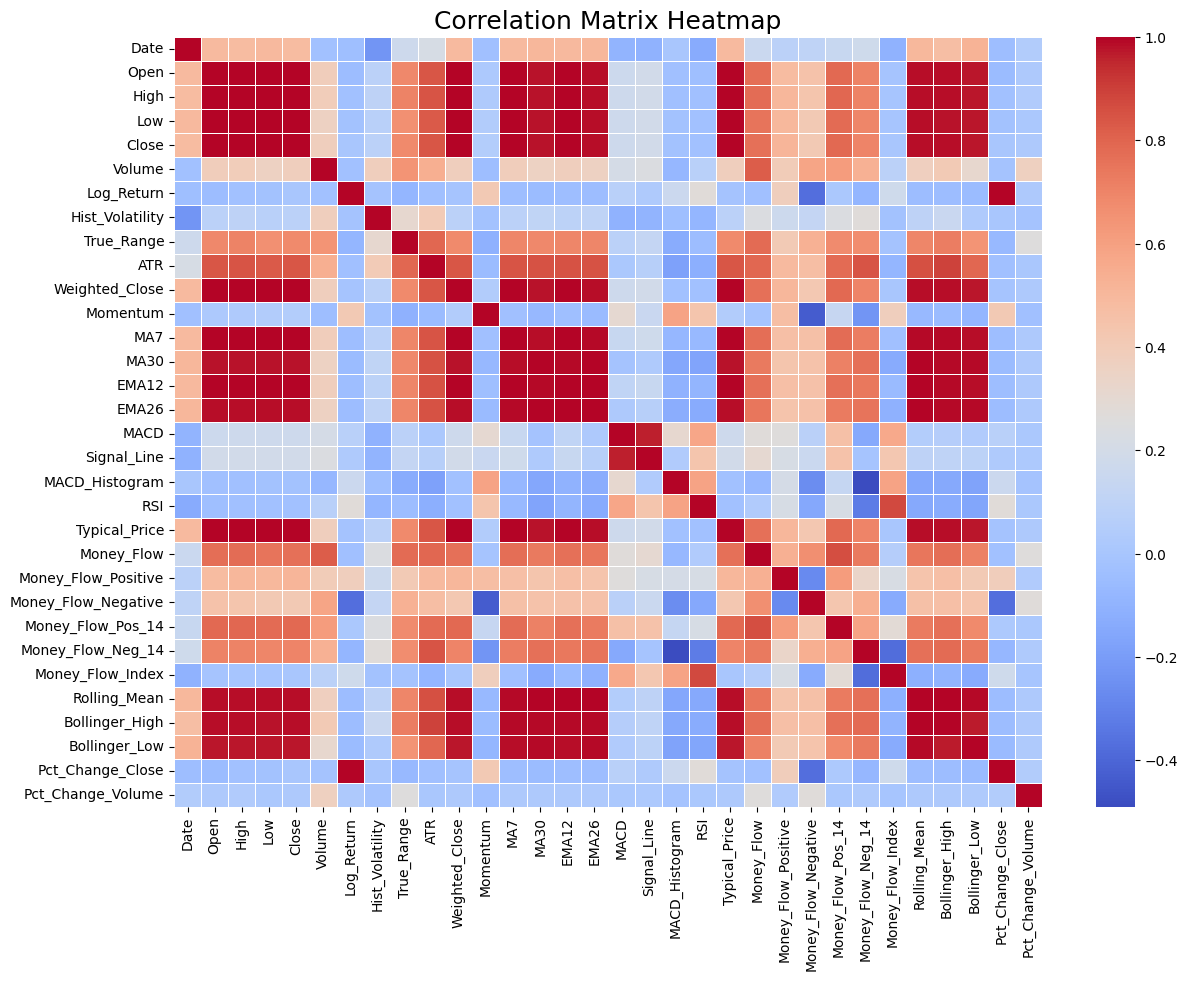

In [16]:
# Plot correlation matrix
plt.figure(figsize=(14, 10))

correlation_matrix = df_btc.corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, linewidths=.5)

plt.title('Correlation Matrix Heatmap', fontsize=18)

plt.show()


- **Price Correlation:** Open, High, Low, and Close prices are highly correlated with each other, which is expected since these prices within a single trading day are often influenced by similar factors and tend to move together.

- **Moving Averages:** MA7 and MA30 (7-day and 30-day moving averages) show strong positive correlations with the price variables (Open, Close, High, Low), suggesting that these moving averages accurately track the price movements over time. Similar observations can be made for EMA12 and EMA26 (12-day and 26-day exponential moving averages).

- **Volatility & Returns:** There is a noticeable correlation between Hist_Volatility and True_Range, which is logical since both are measures related to price variation. Also, Log_Return shows some correlation with these volatility measures, indicating periods of higher returns may be associated with higher volatility (a common observation in financial markets).

- **MACD Analysis:** MACD is calculated using two exponential moving averages (EMA12 and EMA26), and as such, it’s strongly correlated with them. The MACD_Histogram (which represents the difference between MACD and the Signal_Line) also shows a strong negative correlation with the Signal_Line as expected due to their calculation method.

- **Volume & Volatility:** There seems to be some correlation between Volume and volatility measures (Hist_Volatility, True_Range, ATR), indicating that periods of higher trading volumes might be associated with higher volatility in the Bitcoin market.

- **RSI (Relative Strength Index):** RSI does not show a strong correlation with price variables, indicating that it might offer independent information regarding the overbought or oversold condition of Bitcoin, which can be useful for trading strategies.

- **Bollinger Bands:** Bollinger_High and Bollinger_Low show a strong correlation with price variables and moving averages, providing a sense of the price volatility and potential overbought/oversold conditions in different time periods.

- **Money Flow:** Various money flow indicators do not show strong correlations with price variables, potentially offering additional, independent insights into the buying and selling pressure over time.

- **Volume & Volatility:** There seems to be some correlation between Volume and volatility measures (Hist_Volatility, True_Range, ATR), indicating that periods of higher trading volumes might be associated with higher volatility in the Bitcoin market.

- **Relative Strength Index:** RSI does not show a strong correlation with price variables, indicating that it might offer independent information regarding the overbought or oversold condition of Bitcoin, which can be useful for trading strategies.

### Statiscal Analysis
Statistical analysis is performed to understand the distribution of the data and identify any outliers. The following observations are made:

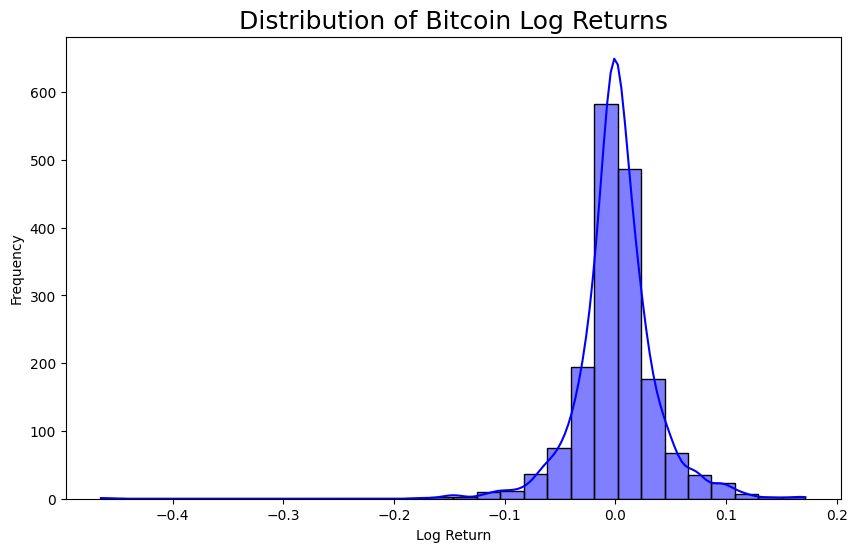

In [17]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot the distribution of log returns
sns.histplot(df_btc['Log_Return'], bins=30, kde=True, color='blue')

# Set the title and labels
plt.title('Distribution of Bitcoin Log Returns', fontsize=18)
plt.xlabel('Log Return')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(data=df_btc,x='month',y='Close')
ax.set_title('Close price by month. ')